In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [8]:
def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    if chroma:
        stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result
    # print(X)


In [5]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe RAVDESS
observed_emotions=['neutral','calm','happy','sad','angry','fearful', 'disgust','surprised']

emotions_2={
  'neutral':'neutral',
  'happy':'happy',
  'sad':'sad',
  'angry':'angry',
  'fear':'fear',
  'disgust':'disgust',
  'ps':'surprised'
}
# Emotions to observe TESS
observed_emotions_2=['neutral','happy','sad','angry','fear', 'disgust','ps']

In [8]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob('Actor_speech/Actor_*/*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    for file in glob.glob('Tess/OAF_*/*.wav'):
        file_name=os.path.basename(file)
        emotion2=emotions_2[file_name.split("_")[2][:-4]]
        if emotion2 not in observed_emotions_2:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion2)
    return x,y  # Return a single tuple containing x and y


In [9]:
x,y = load_data(test_size=0.25)

In [19]:
import time
x_train,x_test,y_train,y_test=train_test_split(np.array(x), y, test_size=0.25, train_size= 0.75,random_state=9)

In [20]:
print((x_train.shape[0], x_test.shape[0]))

(3639, 1213)


In [21]:
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


In [22]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [23]:
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [24]:
y_pred=model.predict(x_test)

In [25]:
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 81.95%


In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.86      0.93      0.90       205
        calm       0.52      0.93      0.67        99
     disgust       0.97      0.72      0.83       149
        fear       0.98      0.99      0.98        98
     fearful       0.76      0.61      0.68        83
       happy       0.92      0.75      0.83       196
     neutral       1.00      0.81      0.89       150
         sad       0.82      0.82      0.82       187
   surprised       0.47      0.76      0.58        46

    accuracy                           0.82      1213
   macro avg       0.81      0.81      0.80      1213
weighted avg       0.86      0.82      0.83      1213



In [27]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test,y_pred)
print (matrix)

[[191   1   0   2   3   0   0   2   6]
 [  1  92   0   0   1   1   0   2   2]
 [  6  14 107   0   5   2   0   4  11]
 [  0   0   0  97   0   1   0   0   0]
 [  8   6   0   0  51   4   0  12   2]
 [ 10  22   2   0   3 147   0   4   8]
 [  1  17   0   0   0   0 121   8   3]
 [  3  19   0   0   3   2   0 153   7]
 [  1   5   1   0   1   2   0   1  35]]


In [30]:
history = model.fit(x_train, y_train)

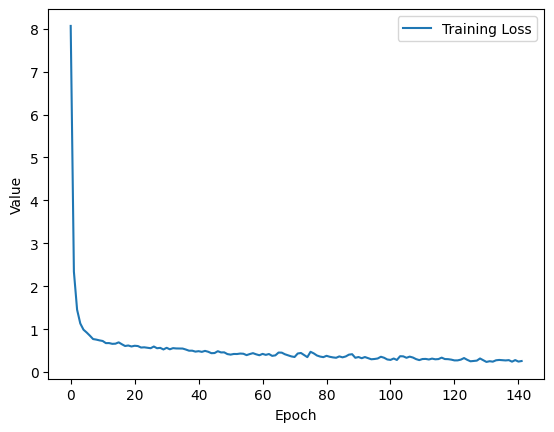

In [33]:
plt.plot(history.loss_curve_, label='Training Loss')
# plt.plot(history.score(x_train, y_train), label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [42]:
score = history.score(x_train, y_train)
print("Score: {:.2f}%".format(score * 100))

Score: 92.14%


In [36]:
accuracy = model.score(x_test, y_test)
loss = model.loss_
# print the accuracy and model loss
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Model Loss: {:.4f}".format(loss))

Accuracy: 83.02%
Model Loss: 0.2584


In [37]:
import joblib
filename = 'Mix_Model_2.sav'
joblib.dump(model, filename)

['Mix_Model_2.sav']

In [130]:
audio_file = "./test_angry.wav"
y, sr = librosa.load(audio_file)
# Compute pitch values using the autocorrelation method
# f0, voiced_flags, voiced_probs = librosa.core.pitch(y=y, sr=sr, method='mcleod')
# Print the pitch values
# print(f0)
pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr, fmin=75, fmax=1600)
# np.set_printoptions(threshold=np.nan)
print(pitches[np.nonzero(pitches)].shape[0])
print(pitches.shape[0])
import librosa
# Load audio file
y, sr = librosa.load("./test_angry.wav")
# Extract amplitude
amplitude = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
# Extract frequency
frequencies, magnitudes = librosa.magphase(librosa.stft(y))
frequency = librosa.fft_frequencies(sr=sr)
# Extract tone and pitch
tone = librosa.feature.tonnetz(y=y, sr=sr)
# pitch = librosa.core.pitch(y=y, sr=sr, fmin=75, fmax=1600)
# Extract pitch information
pitch_freq, pitch_mag = librosa.piptrack(y=y, sr=sr, fmin=75, fmax=1600)
# Print the pitch values
print(pitch_freq)

3857
1025


In [15]:
import joblib

file_n = "Mix_Model_2.sav"
model = joblib.load(file_n)

In [7]:
f = "./Angry.wav"
test = extract_feature(f,mfcc=True, chroma=True, mel=True)

[ 1.2042243e-04  4.2161848e-03 -6.4544973e-04 ...  1.1732723e-06
 -8.9329336e-07  0.0000000e+00]


NoneType

In [19]:
test = test.reshape(1, -1)
test.shape[1]
pred_test=model.predict(test)
pred_test

array(['angry'], dtype='<U9')

In [ ]:
# def load_data(test_size=0.2):
#     x,y=[],[]
#     # for file in glob.glob('D:\Minor 2\Github Ab\Speech-Emotion-Recognition-using-ML-and-DL-master\MLP classifier\Actor_*/*.wav'):
#     for file in glob.glob('Actor_speech/Actor_*/*.wav'):
#         file_name=os.path.basename(file)
#         emotion=emotions[file_name.split("-")[2]]
#         # print(emotions)
#         if emotion not in observed_emotions:
#             continue
#         feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
#         x.append(feature)
#         y.append(emotion)
#     for file in glob.glob('Tess/OAF_*/*.wav'):
#         file_name=os.path.basename(file)
#         emotion2=emotions_2[file_name.split("_")[2][:-4]]
#         # print(emotion2)
#         if emotion2 not in observed_emotions_2:
#             continue
#             # print("yes")
#         feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
#         x.append(feature)
#         y.append(emotion2)
#     # return train_test_split(np.array(x), y, test_size=test_size, train_size= 0.75,random_state=9)
#     return x,y